In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/kidneyData.csv
/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (3178).jpg
/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (3561).jpg
/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (900).jpg
/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (1148).jpg
/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (268).jpg
/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S

# import Libraries 

In [45]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from sklearn.metrics import roc_curve, auc
import matplotlib.image as mpimg
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout , Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import random
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [3]:
base_dir = r'/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'


In [4]:
classes = ['Cyst', 'Tumor', 'Stone', 'Normal']


In [5]:
data = []
for label in classes:
    folder_path = os.path.join(base_dir, label)
    for file in os.listdir(folder_path):
        if file.endswith(('jpg')):  
            file_path = os.path.join(folder_path, file)
            data.append((file_path, label))

In [6]:
df = pd.DataFrame(data, columns=['file_path', 'label'])

In [7]:
df.head()

,file_path,label
0,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst
1,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst
2,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst
3,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst
4,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst


In [8]:
df.shape

(12446, 2)

In [9]:
df['label'].value_counts()

label
Normal    5077
Cyst      3709
Tumor     2283
Stone     1377
Name: count, dtype: int64

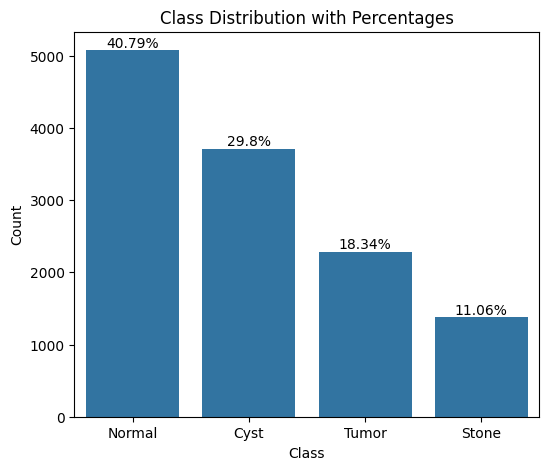

In [10]:
value_counts = df['label'].value_counts().reset_index()
value_counts.columns = ['label', 'count']
value_counts['percentage'] = (value_counts['count'] / value_counts['count'].sum() * 100).round(2)
plt.figure(figsize=(6,5))
ax = sns.barplot(data=value_counts, x='label', y='count')
for i, row in value_counts.iterrows():
    ax.text(i, row['count'], f"{row['percentage']}%", ha='center', va='bottom', fontsize=10, color='black')

plt.title("Class Distribution with Percentages")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

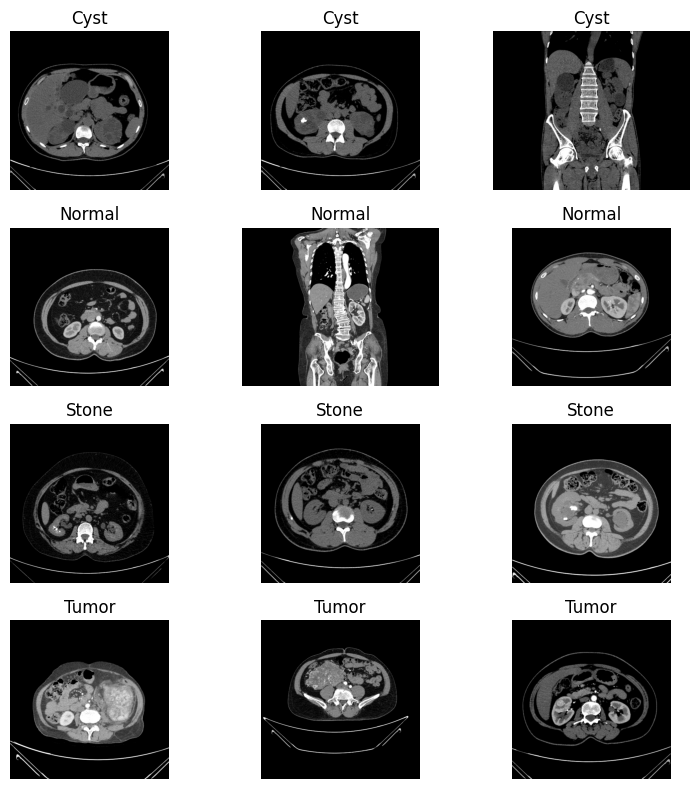

In [72]:
classes_to_display = ['Cyst', 'Normal', 'Stone', 'Tumor']
fig, axes = plt.subplots(4, 3, figsize=(8, 8))  
axes = axes.flatten()  

for i, label in enumerate(classes_to_display):
    class_data = df[df['label'] == label]
    sample_images = random.sample(list(class_data['file_path']), 3)
    
    for j, img_path in enumerate(sample_images):
        img = mpimg.imread(img_path) 
        axes[i * 3 + j].imshow(img)  
        axes[i * 3 + j].axis('off')  
        axes[i * 3 + j].set_title(label)  
plt.tight_layout()
plt.show()

In [12]:
df['binary_label'] = df['label'].apply(lambda x: 0 if x == 'Normal' else 1)


In [13]:
df.head()

,file_path,label,binary_label
0,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst,1
1,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst,1
2,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst,1
3,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst,1
4,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst,1


In [14]:
df['binary_label'].value_counts()


binary_label
1    7369
0    5077
Name: count, dtype: int64

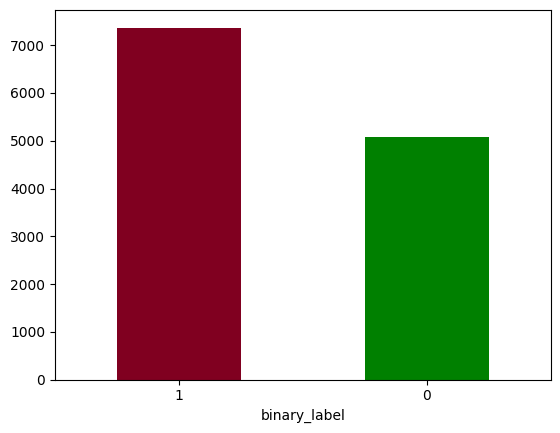

In [15]:
value_counts = df['binary_label'].value_counts()
ax = value_counts.plot(kind='bar', color=['#800020', 'green'])
plt.xticks(rotation=360)
plt.grid(False)

plt.show()


In [16]:
df['label'].value_counts()


label
Normal    5077
Cyst      3709
Tumor     2283
Stone     1377
Name: count, dtype: int64

# undersampling 

> ***tyr to make the data balanced***
> 
> ***delete from the cyst categroy 1500 image to make normal and upnormal close to each other***

In [17]:
df = df.drop(df[df['label'] == 'Cyst'].head(1500).index)

In [18]:
df['label'].value_counts()

label
Normal    5077
Tumor     2283
Cyst      2209
Stone     1377
Name: count, dtype: int64

In [19]:
df['binary_label'].value_counts()

binary_label
1    5869
0    5077
Name: count, dtype: int64

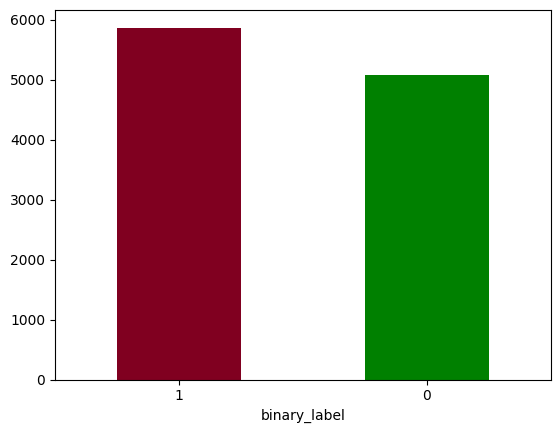

In [20]:
value_counts = df['binary_label'].value_counts()
ax = value_counts.plot(kind='bar', color=['#800020', 'green'])
plt.xticks(rotation=360)
plt.grid(False)

plt.show()


# image processing 

# split data

***split data into train 90% , val 5% , test 5%***


In [21]:
train_df, temp_df = train_test_split(df, test_size=0.1, stratify=df['binary_label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['binary_label'], random_state=42)

In [22]:
print(f"Training size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Testing size: {len(test_df)}")

Training size: 9851
Validation size: 547
Testing size: 548


In [23]:
train_df

,file_path,label,binary_label
9398,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Normal,0
2554,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst,1
5121,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Tumor,1
2002,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst,1
7494,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Normal,0
...,...,...,...
10772,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Normal,0
9335,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Normal,0
10051,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Normal,0
4311,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Tumor,1


In [24]:
train_df['binary_label'].value_counts()

binary_label
1    5282
0    4569
Name: count, dtype: int64

# preprocessing 

In [25]:
train_df['binary_label'] = train_df['binary_label'].astype(str)
val_df['binary_label'] = val_df['binary_label'].astype(str)
test_df['binary_label'] = test_df['binary_label'].astype(str)

In [26]:
def to_grayscale(img):
    if img.shape[-1] == 3:      
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    elif img.shape[-1] == 1:     
        gray = img.squeeze(-1)
    else:
        raise ValueError(f"Unexpected number of channels: {img.shape[-1]}")
    gray = np.expand_dims(gray, axis=-1)  
    return gray.astype(np.float32)

In [27]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,          
    width_shift_range=0.05,     
    height_shift_range=0.05,
    zoom_range=0.05,             
    horizontal_flip=True,       
    fill_mode='nearest',
    preprocessing_function=to_grayscale
)

In [28]:
datagen = ImageDataGenerator(rescale=1.0/255,
                            preprocessing_function=to_grayscale)

In [29]:
binary_train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='file_path',
    y_col='binary_label',
    target_size=(224, 224),
    color_mode='grayscale',    
    batch_size=64,
    class_mode='binary',
    shuffle=True
)

Found 9851 validated image filenames belonging to 2 classes.


In [30]:
binary_val_gen = datagen.flow_from_dataframe(
    val_df,
    x_col='file_path',
    y_col='binary_label',
    target_size=(224, 224),
    color_mode='grayscale',
    batch_size=64,
    class_mode='binary'
)

Found 547 validated image filenames belonging to 2 classes.


In [31]:
binary_test_gen = datagen.flow_from_dataframe(
    test_df,
    x_col='file_path',
    y_col='binary_label',
    target_size=(224, 224),
    color_mode='grayscale',
    batch_size=64,
    class_mode='binary',
    shuffle=False
)

Found 548 validated image filenames belonging to 2 classes.


# model 

> ***binary model*** 

> i have input shape that (22, 224 , 1 ) 
 
> 5 CNN layers

> 2 ANN layers

> binary output with sigmoid function

In [32]:
binary_model = models.Sequential([
    layers.Input(shape=(224, 224, 1)),
    layers.Conv2D(16, (3, 3), activation='relu' , padding = 'same'), 
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(32, (3, 3), activation='relu' , padding = 'same'), 
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(64, (3, 3), activation='relu' , padding = 'same'), 
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(128, (3, 3), activation='relu' , padding = 'same'), 
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(128, (3, 3), activation='relu' , padding = 'same'), 
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])


I0000 00:00:1765984245.772936      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [33]:
binary_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 648,321 (2.47 MB)

 Trainable params: 648,321 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
binary_model.compile(optimizer=Adam(learning_rate=0.00001),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [35]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [36]:
classes = np.unique(train_df['binary_label'])

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_df['binary_label']
)

class_weight_dict = dict(zip(classes, class_weights))
print(class_weight_dict)


{'0': np.float64(1.0780258262201794), '1': np.float64(0.932506626277925)}


In [37]:
history = binary_model.fit(
    binary_train_gen,
    epochs=20,
    validation_data=binary_val_gen,
    callbacks=[early_stopping],
    class_weight=class_weight_dict
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1765984251.525619     122 service.cc:152] XLA service 0x7e1fe8003bb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765984251.525670     122 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1765984252.138586     122 cuda_dnn.cc:529] Loaded cuDNN version 91002


  1/154 ━━━━━━━━━━━━━━━━━━━━ 27:16 11s/step - accuracy: 0.5625 - loss: 0.6862

I0000 00:00:1765984259.341171     122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


154/154 ━━━━━━━━━━━━━━━━━━━━ 124s 738ms/step - accuracy: 0.5849 - loss: 0.6597 - val_accuracy: 0.7733 - val_loss: 0.5226
Epoch 2/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 66s 426ms/step - accuracy: 0.7846 - loss: 0.4822 - val_accuracy: 0.8227 - val_loss: 0.4649
Epoch 3/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 67s 433ms/step - accuracy: 0.8090 - loss: 0.4339 - val_accuracy: 0.7788 - val_loss: 0.4531
Epoch 4/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 66s 425ms/step - accuracy: 0.8118 - loss: 0.4174 - val_accuracy: 0.8537 - val_loss: 0.3748
Epoch 5/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 65s 423ms/step - accuracy: 0.8529 - loss: 0.3469 - val_accuracy: 0.8976 - val_loss: 0.3362
Epoch 6/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 66s 430ms/step - accuracy: 0.8551 - loss: 0.3275 - val_accuracy: 0.8903 - val_loss: 0.3096
Epoch 7/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 66s 429ms/step - accuracy: 0.8825 - loss: 0.2809 - val_accuracy: 0.9177 - val_loss: 0.2695
Epoch 8/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 66s 431ms/step - accuracy: 0.8866 - loss: 0.2670 - va

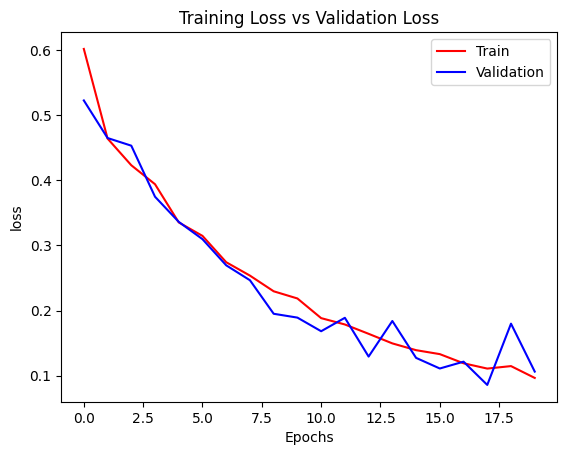

In [38]:
plt.title('Training Loss vs Validation Loss')
plt.plot(history.history['loss'], color='red', label='Train')
plt.plot(history.history['val_loss'], color='blue', label='Validation')

plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

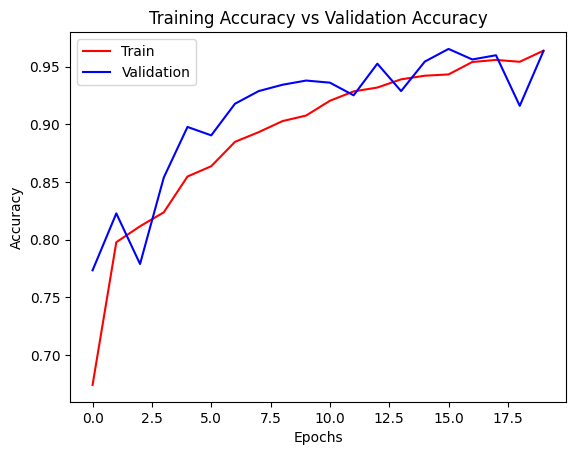

In [39]:
plt.title('Training Accuracy vs Validation Accuracy')
plt.plot(history.history['accuracy'], color='red', label='Train')
plt.plot(history.history['val_accuracy'], color='blue', label='Validation')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

> ***evaluation***

In [40]:
test_loss_binary, test_accuracy_binary = binary_model.evaluate(binary_test_gen)

9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 752ms/step - accuracy: 0.9808 - loss: 0.0674


In [41]:
print(f"Loss: {test_loss_binary}")
print(f"Accuracy: {test_accuracy_binary}")

Loss: 0.06798890233039856
Accuracy: 0.9781022071838379


In [42]:
y_pred_prob = binary_model.predict(binary_test_gen)  


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step


In [43]:
y_true = binary_test_gen.classes

In [46]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

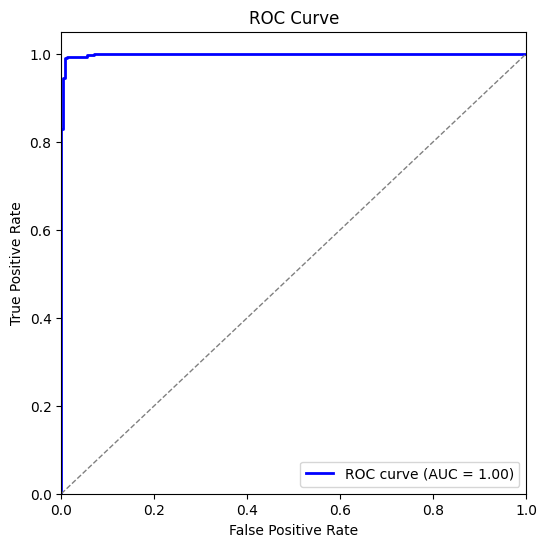

In [47]:
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [50]:
y_pred = (y_pred_prob > 0.5).astype(int)

In [51]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       254
           1       0.97      0.99      0.98       294

    accuracy                           0.98       548
   macro avg       0.98      0.98      0.98       548
weighted avg       0.98      0.98      0.98       548



In [52]:
cm = confusion_matrix(y_true, y_pred)

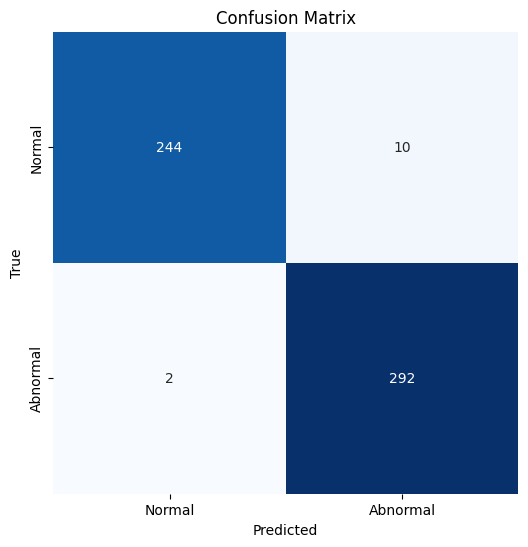

In [53]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

> ***classification model***

In [57]:
abnormal_df = df[df['label'].isin(['Cyst', 'Stone', 'Tumor'])]

In [58]:
abnormal_df.head()

,file_path,label,binary_label
1500,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst,1
1501,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst,1
1502,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst,1
1503,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst,1
1504,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst,1


In [59]:
abnormal_df.shape

(5869, 3)

In [60]:
abnormal_df['label'].value_counts()

label
Tumor    2283
Cyst     2209
Stone    1377
Name: count, dtype: int64

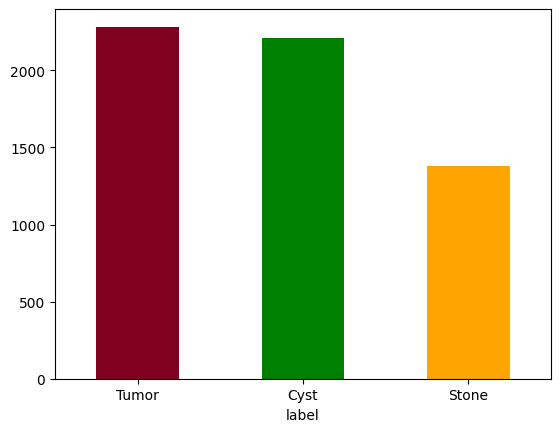

In [61]:
value_counts = abnormal_df['label'].value_counts()
ax = value_counts.plot(kind='bar', color=['#800020', 'green','orange'])
plt.xticks(rotation=360)
plt.grid(False)

plt.show()


In [62]:
train_abnormal_df, temp_df = train_test_split(abnormal_df, test_size=0.1, stratify=abnormal_df['label'], random_state=42)
val_abnormal_df, test_abnormal_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

In [63]:
print(f"Training size: {len(train_abnormal_df)}")
print(f"Validation size: {len(val_abnormal_df)}")
print(f"Testing size: {len(test_abnormal_df)}")

Training size: 5282
Validation size: 293
Testing size: 294


In [64]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    preprocessing_function=to_grayscale
)


In [65]:
multiclass_train_gen = train_datagen.flow_from_dataframe(
    train_abnormal_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    color_mode='grayscale',
    batch_size=64,
    class_mode='categorical'
)

Found 5282 validated image filenames belonging to 3 classes.


In [66]:
multiclass_val_gen = datagen.flow_from_dataframe(
    val_abnormal_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    color_mode='grayscale',
    batch_size=64,
    class_mode='categorical'
)

Found 293 validated image filenames belonging to 3 classes.


In [67]:
multiclass_test_gen = datagen.flow_from_dataframe(
    test_abnormal_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    color_mode='grayscale',
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 294 validated image filenames belonging to 3 classes.


In [138]:
multiclass_model = models.Sequential([
    layers.Input(shape=(224, 224, 1)),
    layers.Conv2D(16, (3, 3), activation='relu' , padding = 'same'), 
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(32, (3, 3), activation='relu' , padding = 'same'), 
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu' , padding = 'same'), 
    layers.MaxPooling2D((2, 2)),
   
    layers.Conv2D(128, (3, 3), activation='relu' , padding = 'same'), 
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu' , padding = 'same'), 
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(3, activation='softmax')
])

In [139]:
multiclass_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_45 (Conv2D)              │ (None, 224, 224, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 648,387 (2.47 MB)

 Trainable params: 648,387 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

In [140]:
multiclass_model.compile(optimizer=Adam(learning_rate=0.0001),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

In [141]:
history= multiclass_model.fit(multiclass_train_gen,
                     validation_data=multiclass_val_gen,
                     epochs=20,
                     class_weight=class_weight_dict
                             )

Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 42s 461ms/step - accuracy: 0.4874 - loss: 1.0564 - val_accuracy: 0.5802 - val_loss: 0.7975
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 36s 429ms/step - accuracy: 0.6346 - loss: 0.7765 - val_accuracy: 0.7235 - val_loss: 0.6148
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 36s 439ms/step - accuracy: 0.7137 - loss: 0.6479 - val_accuracy: 0.8157 - val_loss: 0.5021
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 36s 430ms/step - accuracy: 0.7672 - loss: 0.5429 - val_accuracy: 0.7577 - val_loss: 0.5524
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 36s 439ms/step - accuracy: 0.8083 - loss: 0.4767 - val_accuracy: 0.8874 - val_loss: 0.3689
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 36s 437ms/step - accuracy: 0.8565 - loss: 0.3850 - val_accuracy: 0.8874 - val_loss: 0.2908
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 36s 429ms/step - accuracy: 0.8791 - loss: 0.3311 - val_accuracy: 0.9352 - val_loss: 0.2345
Epoch 8/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 36s 435ms/step - accuracy: 0.8957 - loss: 0.3004 - val_accu

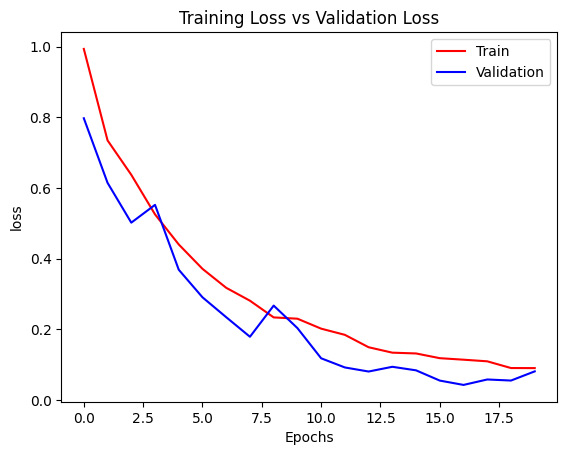

In [142]:
plt.title('Training Loss vs Validation Loss')
plt.plot(history.history['loss'], color='red', label='Train')
plt.plot(history.history['val_loss'], color='blue', label='Validation')

plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

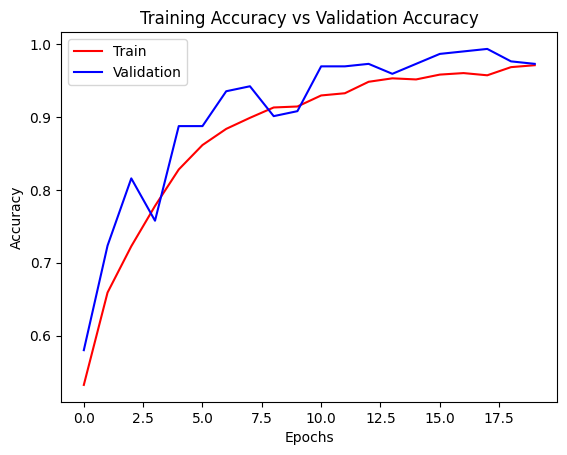

In [143]:
plt.title('Training Accuracy vs Validation Accuracy')
plt.plot(history.history['accuracy'], color='red', label='Train')
plt.plot(history.history['val_accuracy'], color='blue', label='Validation')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

> evalution 

In [144]:
test_loss_multi, test_accuracy_multi = multiclass_model.evaluate(multiclass_test_gen)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 359ms/step - accuracy: 0.9728 - loss: 0.0815


In [145]:
print(f"Loss: {test_loss_multi}")
print(f"Accuracy: {test_accuracy_multi}")


Loss: 0.09165910631418228
Accuracy: 0.9625850319862366


In [146]:
y_pred_probs = multiclass_model.predict(multiclass_test_gen) 

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 273ms/step


In [147]:
y_pred = y_pred_probs.argmax(axis=1)

In [148]:
y_true = multiclass_test_gen.classes  

**0: cyst , 1: stone , 2 : tumor**

In [149]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       111
           1       1.00      0.84      0.91        69
           2       1.00      1.00      1.00       114

    accuracy                           0.96       294
   macro avg       0.97      0.95      0.96       294
weighted avg       0.97      0.96      0.96       294



In [150]:
label_map = {v: k for k, v in multiclass_test_gen.class_indices.items()}
results_df['True_Label_Name'] = results_df['True_Label'].map(label_map)
results_df['Predicted_Label_Name'] = results_df['Predicted_Label'].map(label_map)

In [151]:
cm = confusion_matrix(y_true, y_pred)

In [152]:
class_names = list(multiclass_test_gen.class_indices.keys())

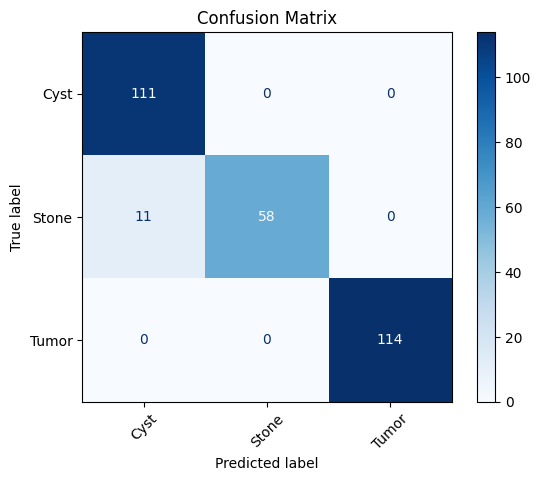

In [153]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()

In [97]:
test_images, test_labels = next(multiclass_test_gen)
predictions = multiclass_model.predict(test_images).argmax(axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step 


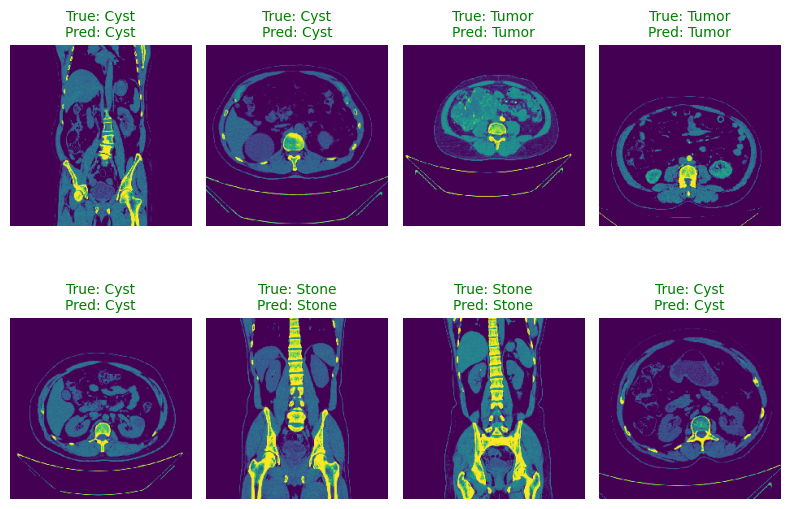

In [98]:
num_images = 8
rows, cols = 2, 4  
plt.figure(figsize=(8, 6)) 

for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    img = test_images[i]
    img = (img * 255).astype(np.uint8)
    plt.imshow(img)
    true_label = label_map[test_labels[i].argmax()]
    predicted_label = label_map[predictions[i]]
    title_color = "green" if true_label == predicted_label else "red"
    plt.title(
        f"True: {true_label}\nPred: {predicted_label}",
        color=title_color,
        fontsize=10
    )
    plt.axis("off")  
    
plt.tight_layout()
plt.show()

# save models 

In [99]:
multiclass_model.save('multiclass_model_final.h5')
binary_model.save('binary_model_final.h5')

# prediction function

In [100]:
binary_model = load_model('binary_model_final.h5')
multiclass_model = load_model('multiclass_model_final.h5')

In [101]:
def predict_pipeline(image_path, binary_model, multiclass_model):
    img = load_img(image_path, target_size=(224, 224))  
    img_array = img_to_array(img) / 255.0 
    img_array = np.expand_dims(img_array, axis=0)  
    
    binary_pred = binary_model.predict(img_array)
    if binary_pred > 0.5:
        multiclass_pred = multiclass_model.predict(img_array)
        class_idx = np.argmax(multiclass_pred) 
        
        class_labels = {0: 'Cyst', 1: 'Stone', 2: 'Tumor'}
        return f"Abnormal: {class_labels[class_idx]}"
    else:
        return "Normal"

In [ ]:
image_path = "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/Tumor- (1024).jpg"
result = predict_pipeline(image_path, binary_model, multiclass_model)
print(result)